In [1]:
import os
import sys

import pandas as pd
import numpy as np

In [9]:
from calculate import calculate_drift, plot_drift

In [13]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12.0, 6.0)

In [3]:
data = pd.read_hdf('sarss.h5', key='sarss')
data.shape

(237646, 14)

# Concept Drift ADWIN

__ADWIN__

* BIFET, Albert; GAVALDA, Ricard. Learning from time-changing data with adaptive windowing. In: Proceedings of the 2007 SIAM international conference on data mining. Society for Industrial and Applied Mathematics, 2007. p. 443-448.


__Page-Hinckley Test__

* GAMA, João; SEBASTIÃO, Raquel; RODRIGUES, Pedro Pereira. On evaluating stream learning algorithms. Machine learning, v. 90, n. 3, p. 317-346, 2013.

## Only experiments with both stations accessing Google

In [4]:
data1 = data[data['sites'] == ('google', 'google')]

In [5]:
y1 = data1['r']
y1 = np.sign(np.concatenate(([1], y1[1:].values - y1[:-1].values)))
y1[y1==-1] = 0  # y will have only 0s and 1s

In [6]:
X1 = data1[['Active time', 'Medium busy', 'channel',
            'new Active time', 'new Busy time', 'new Medium busy',
            'new_channel', 'new_txpower', 'txpower']].values

In [7]:
result = calculate_drift(X1, y1, n_train=1800, w=16)


GaussianNB:
Mean acc within the window 16: 0.8485166176378545

Page-Hinkley:
Mean acc within the window 16: 0.8485166176378545
Drift detection: 0

AdWin:
Mean acc within the window 16: 0.7932496714026412
Drift detection: 122


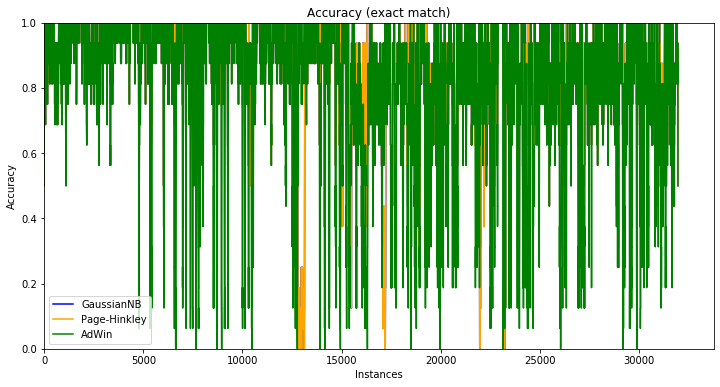

In [14]:
plot_drift(result, plot_circles=[])

# Only one experiment at a time

Use (google, google) experiment, shows only "interval" instances

In [15]:
interval = 1800

In [16]:
n_train = 100
window_size = 16

Experiment #0 from 0 to 1800 - n_train 100 window size 16

AdWin:
Mean acc within the window 16: 0.8883088235294118
Drift detection: 5


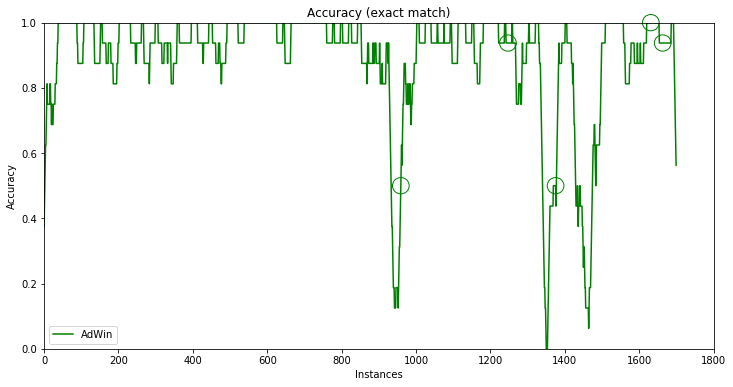

Experiment #1 from 1800 to 3600 - n_train 100 window size 16

AdWin:
Mean acc within the window 16: 0.7927941176470589
Drift detection: 8


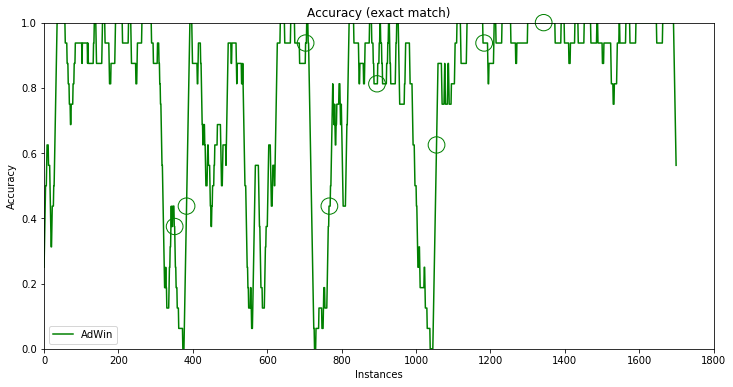

Experiment #2 from 3600 to 5400 - n_train 100 window size 16

AdWin:
Mean acc within the window 16: 0.7801102941176471
Drift detection: 7


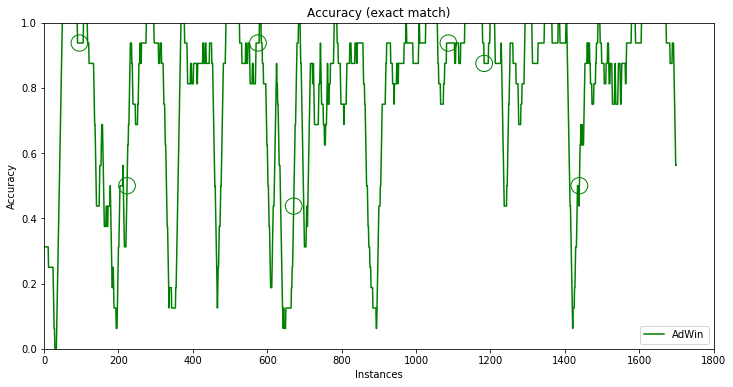

Experiment #3 from 5400 to 7200 - n_train 100 window size 16

AdWin:
Mean acc within the window 16: 0.9264705882352942
Drift detection: 3


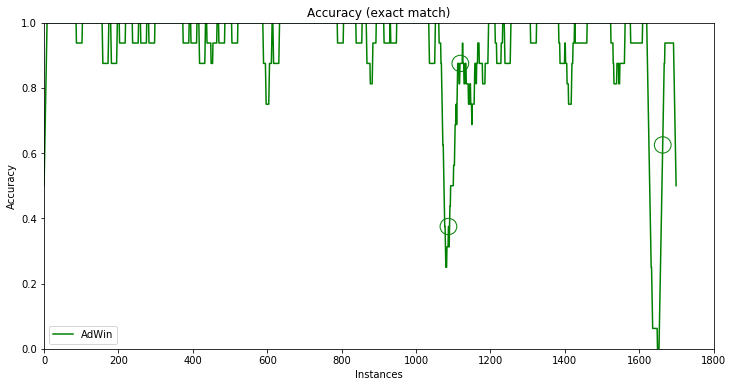

Experiment #4 from 7200 to 9000 - n_train 100 window size 16

AdWin:
Mean acc within the window 16: 0.8232352941176471
Drift detection: 7


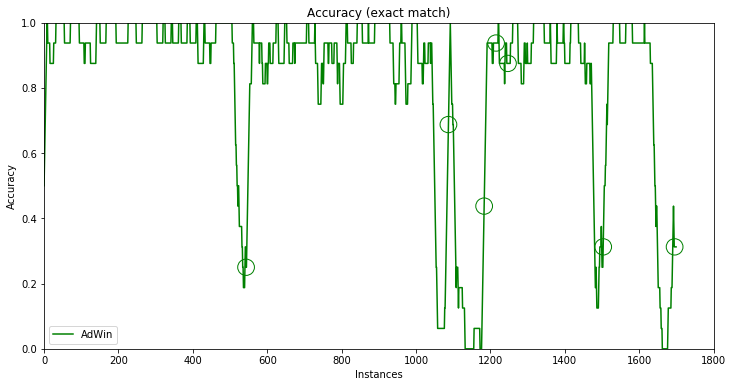

Experiment #5 from 9000 to 10800 - n_train 100 window size 16

AdWin:
Mean acc within the window 16: 0.788860294117647
Drift detection: 11


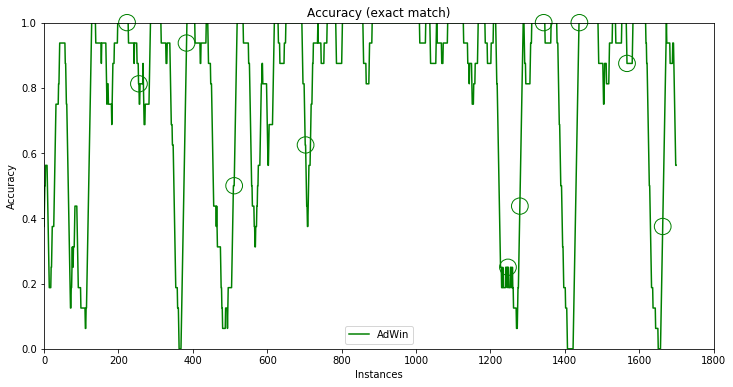

Experiment #6 from 10800 to 12600 - n_train 100 window size 16

AdWin:
Mean acc within the window 16: 0.8253308823529412
Drift detection: 9


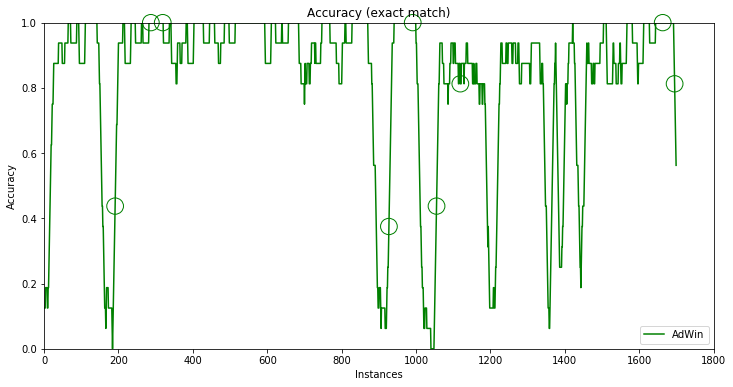

Experiment #7 from 12600 to 14400 - n_train 100 window size 16

AdWin:
Mean acc within the window 16: 0.8243382352941176
Drift detection: 5


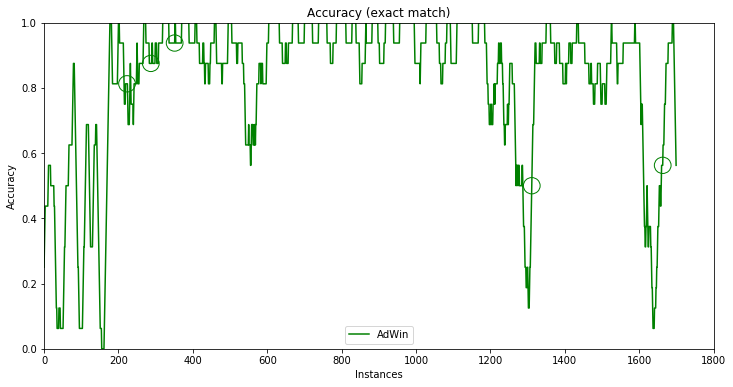

Experiment #8 from 14400 to 16200 - n_train 100 window size 16

AdWin:
Mean acc within the window 16: 0.8368382352941176
Drift detection: 6


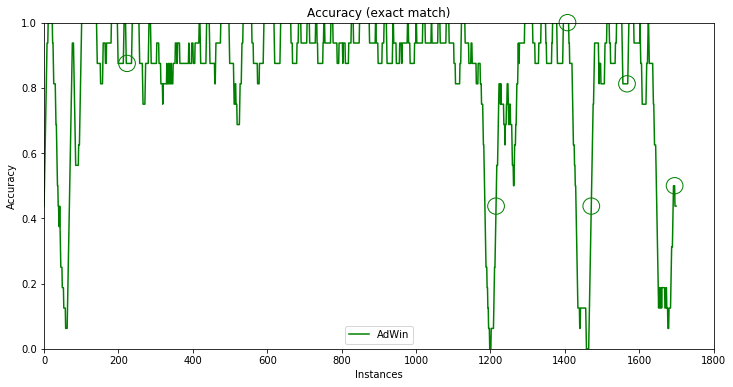

Experiment #9 from 16200 to 18000 - n_train 100 window size 16

AdWin:
Mean acc within the window 16: 0.6940808823529412
Drift detection: 10


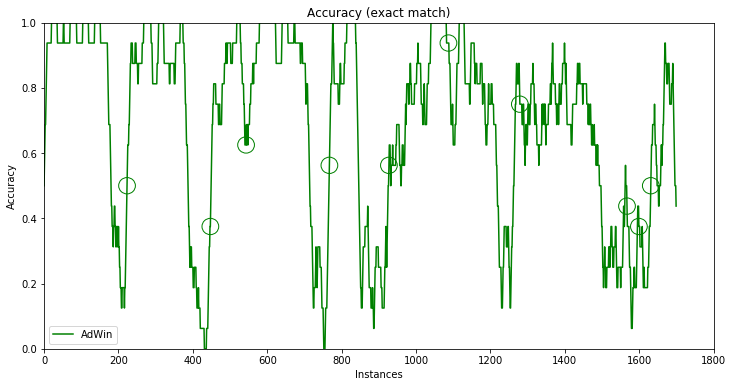

In [17]:
for i in range(10):
    li = interval * i
    ls = li + 1800
    y_ = y1[li:ls]
    X_ = X1[li:ls]
    print("Experiment #{} from {} to {} - n_train {} window size {}".format(i, li, ls, n_train, window_size))
    result = calculate_drift(X_, y_, n_train=n_train, w=window_size, clfs_label=["AdWin"])
    plot_drift(result)

# Changing n_train 

Experiment #0 from 0 to 1800 - n_train = 10 window size = 16

AdWin:
Mean acc within the window 16: 0.8752444134078212
Drift detection: 7


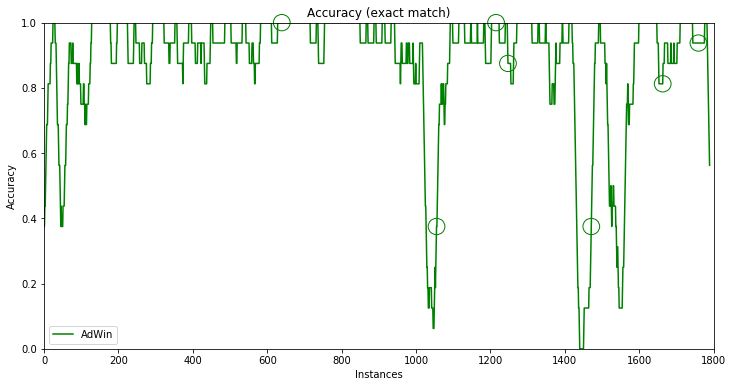

Experiment #1 from 1800 to 3600 - n_train = 20 window size = 16
Error in class
Experiment #2 from 3600 to 5400 - n_train = 30 window size = 16
Error in class
Experiment #3 from 5400 to 7200 - n_train = 40 window size = 16
Error in class
Experiment #4 from 7200 to 9000 - n_train = 50 window size = 16

AdWin:
Mean acc within the window 16: 0.8749285714285714
Drift detection: 3


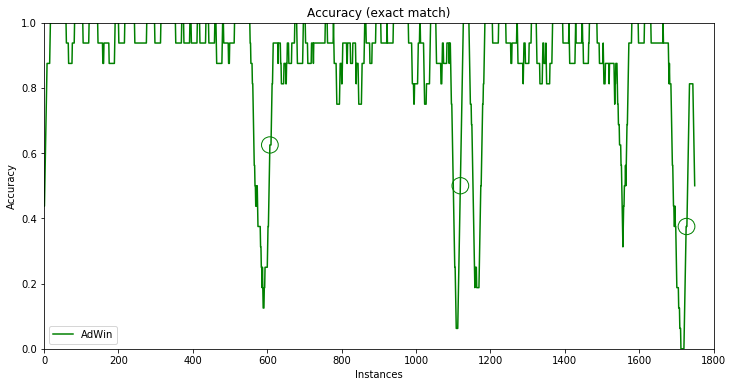

Experiment #5 from 9000 to 10800 - n_train = 80 window size = 16

AdWin:
Mean acc within the window 16: 0.8168604651162791
Drift detection: 7


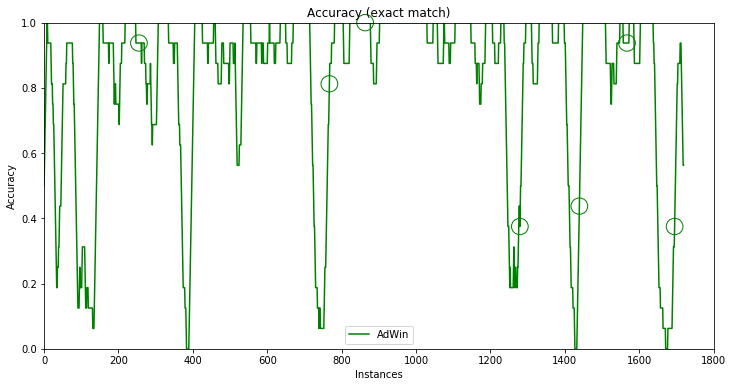

Experiment #6 from 10800 to 12600 - n_train = 100 window size = 16

AdWin:
Mean acc within the window 16: 0.8253308823529412
Drift detection: 9


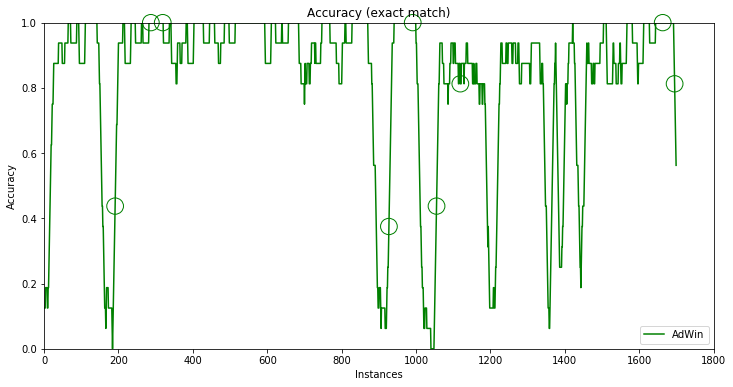

Experiment #7 from 12600 to 14400 - n_train = 150 window size = 16

AdWin:
Mean acc within the window 16: 0.8647348484848485
Drift detection: 4


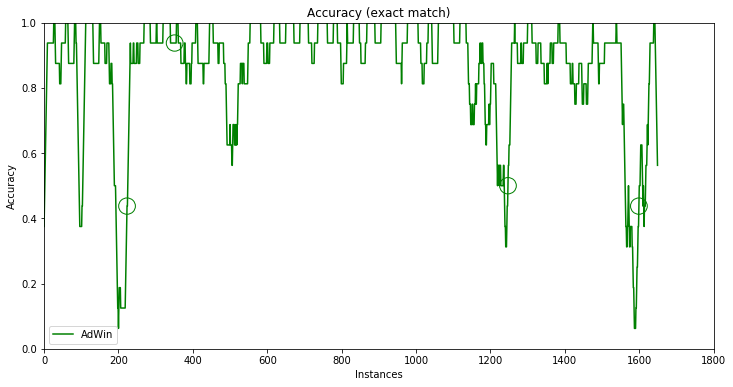

Experiment #8 from 14400 to 16200 - n_train = 200 window size = 16

AdWin:
Mean acc within the window 16: 0.8440625
Drift detection: 6


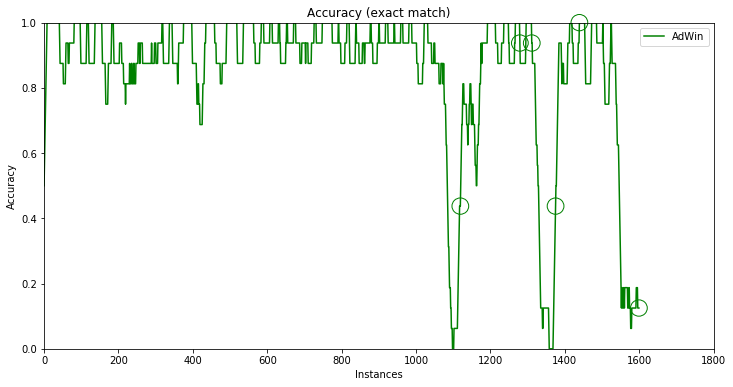

Experiment #9 from 16200 to 18000 - n_train = 300 window size = 16

AdWin:
Mean acc within the window 16: 0.658625
Drift detection: 8


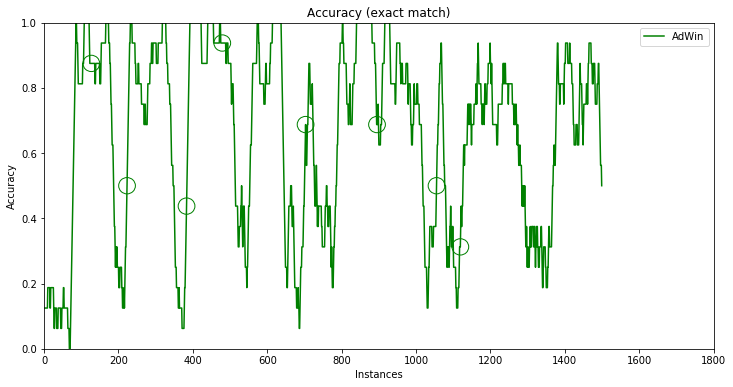

In [18]:
n_train_values = [10, 20, 30, 40, 50, 80, 100, 150, 200, 300]
for i in range(10):
    li = interval * i
    ls = li + 1800
    y_ = y1[li:ls]
    X_ = X1[li:ls]
    n_train = n_train_values[i]
    print("Experiment #{} from {} to {} - n_train = {} window size = {}".format(i, li, ls, n_train, window_size))
    try:
        result = calculate_drift(X_, y_, n_train=n_train, w=window_size, clfs_label=["AdWin"])
        plot_drift(result)
    except ValueError:
        print("Error in class")

# Changing lambda from Page-Hinkley

Experiment #7 from 12600 to 14400 - lambda=10

Page-Hinkley:
Mean acc within the window 16: 0.7821323529411764
Drift detection: 2


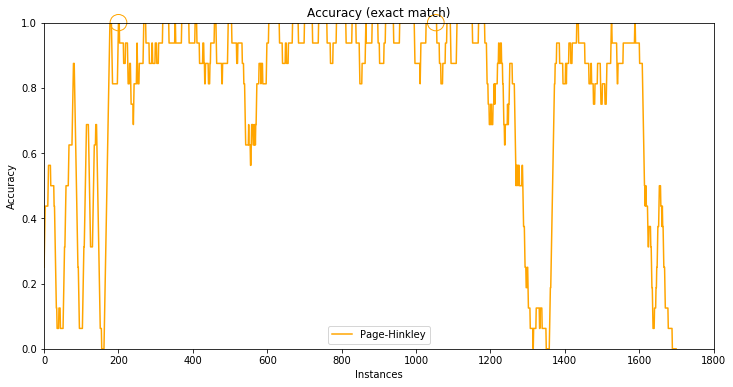

Experiment #7 from 12600 to 14400 - lambda=20

Page-Hinkley:
Mean acc within the window 16: 0.7991911764705882
Drift detection: 2


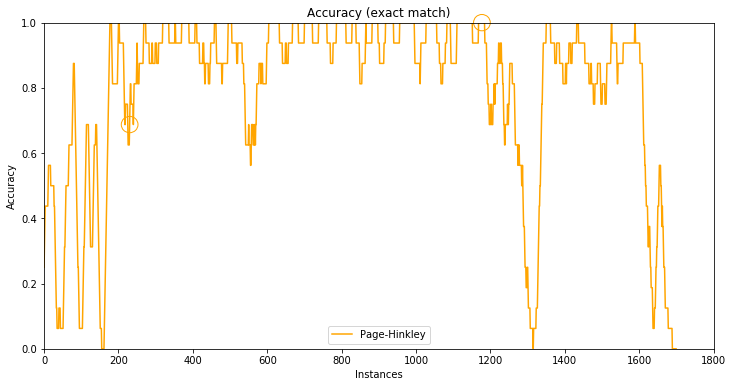

Experiment #7 from 12600 to 14400 - lambda=30

Page-Hinkley:
Mean acc within the window 16: 0.5897794117647058
Drift detection: 1


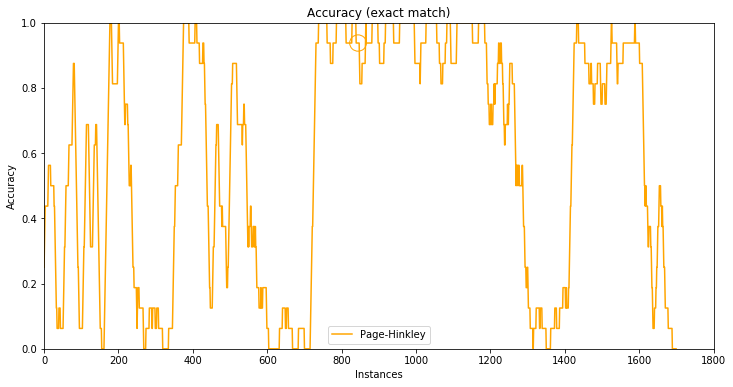

Experiment #7 from 12600 to 14400 - lambda=40

Page-Hinkley:
Mean acc within the window 16: 0.5903676470588235
Drift detection: 1


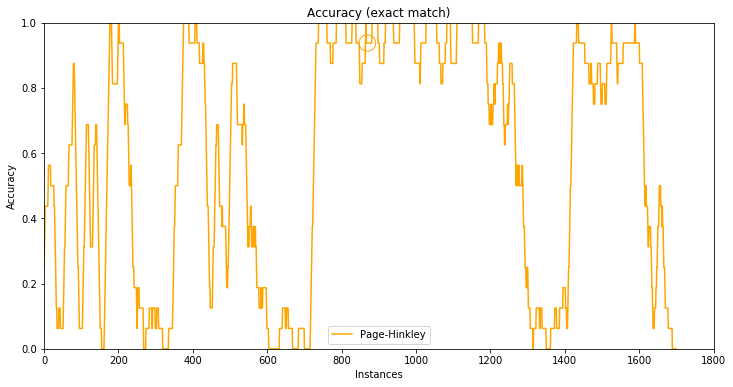

Experiment #7 from 12600 to 14400 - lambda=50

Page-Hinkley:
Mean acc within the window 16: 0.5933088235294117
Drift detection: 1


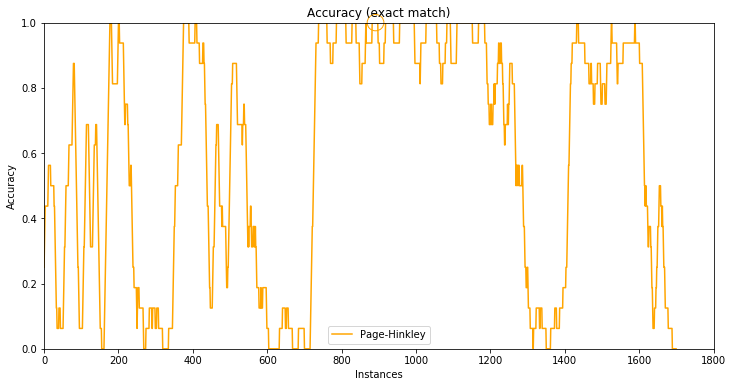

Experiment #7 from 12600 to 14400 - lambda=100

Page-Hinkley:
Mean acc within the window 16: 0.6050735294117647
Drift detection: 1


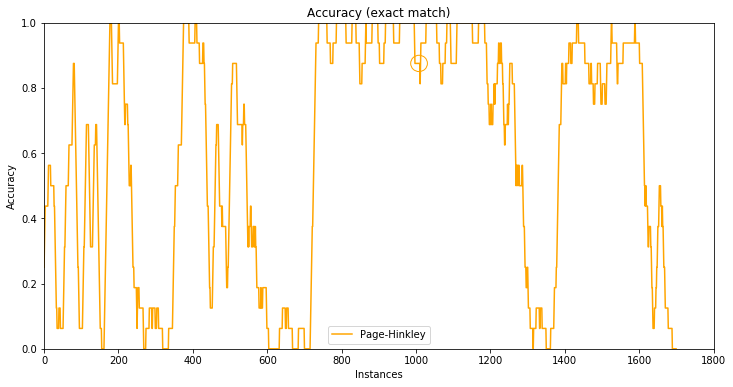

In [19]:
i = 7
for lambda_ in [10, 20, 30, 40, 50, 100]:
    li = interval * i
    ls = li + 1800
    y_ = y1[li:ls]
    X_ = X1[li:ls]
    print("Experiment #{} from {} to {} - lambda={}".format(i, li, ls, lambda_))
    result = calculate_drift(X_, y_, n_train=100, w=16, lambda_=lambda_, 
                             clfs_label=["Page-Hinkley"],
                             )
    plot_drift(result, plot_circles=["Page-Hinkley"])

# varying the window size

In [15]:
y = data['r']
y = np.sign(np.concatenate(([1], y[1:].values - y[:-1].values)))
y[y==-1] = 0  # y will have only 0s and 1s

In [16]:
X = data[['Active time', 'Medium busy', 'channel',
       'new Active time', 'new Busy time', 'new Medium busy',
       'new_channel', 'new_txpower', 'txpower']].values

In [17]:
n_train = 60 * 30  # 30 minutes

In [18]:
num_files = data['file_id'].unique().shape[0]
num_files

190


GaussianNB:
Mean acc within the window 16: 0.8669349471362288

Page-Hinkley:
Mean acc within the window 16: 0.7387009499421077
Drift detection: 72

AdWin:
Mean acc within the window 16: 0.8022896013454696
Drift detection: 677


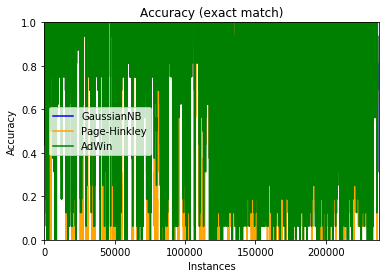

On average 3.5631578947368423 in AdWin

GaussianNB:
Mean acc within the window 32: 0.8669209494350211

Page-Hinkley:
Mean acc within the window 32: 0.7386870842946849
Drift detection: 72

AdWin:
Mean acc within the window 32: 0.8022757356980469
Drift detection: 677


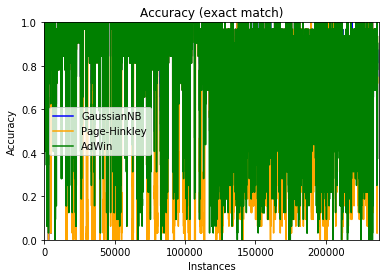

On average 3.5631578947368423 in AdWin

GaussianNB:
Mean acc within the window 64: 0.8668923597905732

Page-Hinkley:
Mean acc within the window 64: 0.7386583625964521
Drift detection: 72

AdWin:
Mean acc within the window 64: 0.802247013999814
Drift detection: 677


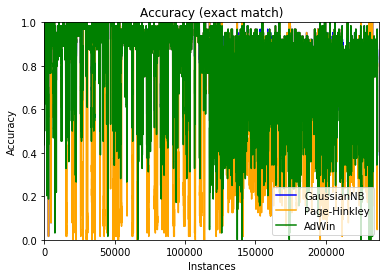

On average 3.5631578947368423 in AdWin

GaussianNB:
Mean acc within the window 128: 0.8668361709050649

Page-Hinkley:
Mean acc within the window 128: 0.7386026358991912
Drift detection: 72

AdWin:
Mean acc within the window 128: 0.8021912873025532
Drift detection: 677


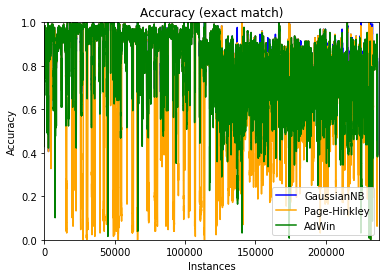

On average 3.5631578947368423 in AdWin

GaussianNB:
Mean acc within the window 256: 0.8667227532104916

Page-Hinkley:
Mean acc within the window 256: 0.7384900600474971
Drift detection: 72

AdWin:
Mean acc within the window 256: 0.8020787114508591
Drift detection: 677


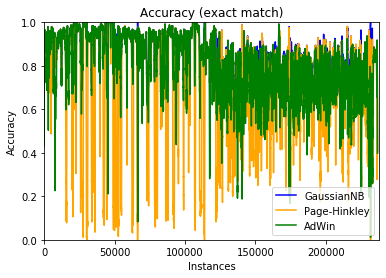

On average 3.5631578947368423 in AdWin

GaussianNB:
Mean acc within the window 512: 0.8664819944003913

Page-Hinkley:
Mean acc within the window 512: 0.7382548474963658
Drift detection: 72

AdWin:
Mean acc within the window 512: 0.8018395455395401
Drift detection: 677


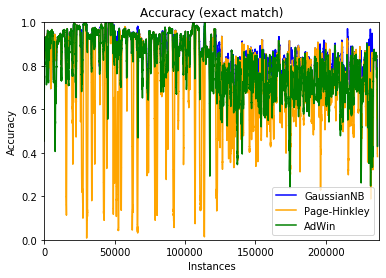

On average 3.5631578947368423 in AdWin


In [19]:
for w in [16, 32, 64, 128, 256, 512]:
    result = calculate_drift(X, y, n_train=1000, w=w)
    plot_drift(result, plot_circles=[])
    adwin = result['clfs']['AdWin']['num']
    print("On average", adwin / num_files, "in AdWin")

In [20]:
print('end')

end
